In [1]:
%matplotlib inline
%reset -f

import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy.random import rand, randint
import matplotlib.pyplot as plt
import os
import fnmatch
import pandas as pd
import bezier

from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure

from PIL import Image, ImageDraw
from keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, UpSampling2D, ZeroPadding2D, Flatten, Conv1D, Conv2D, Conv3D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from keras.layers.merge import add, concatenate

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.4.1


In [2]:
image_width = image_height = 400
gridcell = 10

image_root = './images/multi_lines/train/'
image_labels = ['line']

total_files = fnmatch.filter(os.listdir(image_root), '*.png')
#print(total_files)

df=pd.read_csv('./images/multi_lines/train.csv', sep=',',header=0)

def image_read(fn):
    link = os.path.join(image_root, fn)
    image = Image.open(link).convert('RGB')
    im = np.asarray(image)
    return im


def getInfo(fn):
    image = image_read(fn+".png")
    
    rows = np.where(df.filename==fn)
    
    class_id = df["class"][rows[0][0]]
    coords = []
    
    for i in rows[0]:
        c_id = []
        c_coord = []
        
        c_coord.append(df.xmin[i])
        c_coord.append(df.xmax[i])
        #the Y coordinate axis in the annotations starts at bottom
        #inverting
        c_coord.append(image_height - df.ymin[i])
        c_coord.append(image_height - df.ymax[i])
        
        coords.append(c_coord)
        c_id = []
    
    return image, class_id, coords

# PLOT LINE

In [3]:
def plot_line(image, pred_coords, norm=False):
    figo = Figure(figsize=(2, 2))

    canvas = FigureCanvasAgg(figo)

    # plot
    ax_r = figo.add_subplot()
    if norm:
        image *= 255.
        image = image.astype(np.uint8)
    ax_r.imshow(image)
    
    for i in pred_coords:
        xmin, xmax, ymin, ymax = i
        ax_r.plot([xmin, xmax], [ymin, ymax], 'r+', linestyle='dotted', label='prediction')
    
    ax_r.set_axis_off()

    canvas.draw()

    buf = canvas.buffer_rgba()
    # ... convert to a NumPy array ...
    X = np.asarray(buf)
    # ... and pass it to PIL.
    im = Image.fromarray(X)

    return im

def randlGen():
    '''Returns a random image file name'''
    rElem = np.random.choice(total_files)
    rElem = rElem[0:-4]
    return rElem

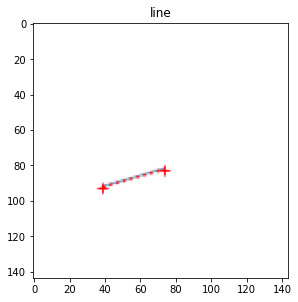

In [4]:
image, class_id, pred_coords = getInfo(randlGen())

image = plot_line(image, pred_coords,norm=False)
plt.imshow(image)
plt.title("line")
plt.tight_layout(pad=0)
plt.show()

***

# Pixel gTruth and Line gTruth

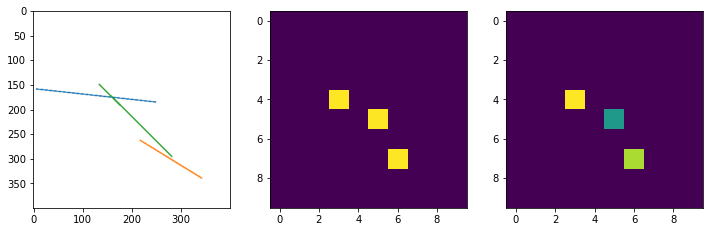

In [5]:
def linear(coord):
    '''Converts coordinates from scale `image_height`x`image_width`
       to scale `gridcell`x`gridcell` '''
    n_a = []
    
    for i in coord:
        OldValue = i
        OldMax = image_width-1
        OldMin = 0
        NewMax = gridcell-1
        NewMin = 0
        OldRange = (OldMax - OldMin)  
        NewRange = (NewMax - NewMin)  
        x = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
        n_a.append(x)
    
    return np.asarray(n_a)

def midPoint(p12):
    x1, x2, y1, y2 = p12
    
    x = (x1 + x2)/2
    y = (y1 + y2)/2
    
    return x,y

def gtruther(index):

    image, class_id, coords = getInfo(index)
    
    #truther shapes
    pxTruth = np.zeros((gridcell,gridcell,1))
    liTruth = np.zeros((gridcell,gridcell,4))
    mps = []
    
    if (class_id == 1):
        for i in coords:
            x1, x2, y1, y2 = i
            
            #mapping
            p12 = linear(i)

            #find mp
            mp = midPoint(p12)
            mp = np.around(mp)
            
            #mp coords
            #y, x = mp.astype(int)
            x, y = mp.astype(int) #x,y same order as in `i`

            #line coords
            x1, x2, y1, y2 = p12

            #allot line gt coords of mp coords to liTruth shape
            liTruth[y][x] = i
            pxTruth[y][x] = [class_id]
            mps.append([y,x])
            

    return image, liTruth, pxTruth, class_id, mps


def test_sbs(index):
    image, class_id, coords = getInfo(index)
    pimg, liTruth, pxTruth, class_id, mps = gtruther(index)
    
    plt.figure(0, (12,8))
    plt.subplot(1, 3, 1)
    #plt.tight_layout(pad=0)
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.imshow(pxTruth)
    plt.subplot(1, 3, 3)
    plt.imshow(liTruth[...,1])
    
test_sbs("li_403")
#test_sbs("li_410")

***
# DATA GEN

In [6]:
batch_size = 32

def regression_weight_map(cls_target):
    '''Creates a weight map for the regression target.
       The weight map is 1.0 where the classification target is not zero.
       Shape=(B,H,W)  (no channel dimension as required by the loss functions)'''
    return (cls_target[...,0] > 0).astype('float32')

def data_generator(batch_size=batch_size):
    while True:
        x_batch = np.zeros((batch_size, image_height, image_width, 3))
        y_batch = np.zeros((batch_size, gridcell, gridcell, 1))
        bline_batch   = np.zeros((batch_size, gridcell, gridcell, 4))

        for i,j in enumerate(total_files[0:batch_size]):
            image, liTruth, pxTruth, class_id, mps = gtruther(randlGen())
            
            x_batch[i] = image / 255.
            y_batch[i] = pxTruth
            bline_batch[i] = liTruth
            
        sample_weight = regression_weight_map(y_batch)
        yield ({'image': x_batch}, {'class_out': y_batch, 'line_out': bline_batch}, {'line_out': sample_weight})

In [7]:
def extractor(class_id, pred_coords):
    #for label
    count = 0
    pos = []
    coords = []

    #gT label
    for i,j in enumerate(class_id):
        for k,l in enumerate(class_id):
            if(class_id[i][k] == 1):
                pos.append([i,k])
                count = count + 1

    for i,j in enumerate(pred_coords):
        for k,l in enumerate(pred_coords):
            if (all(i != 0 for i in pred_coords[i][k])):
                coords.append(pred_coords[i][k])

    return count, coords

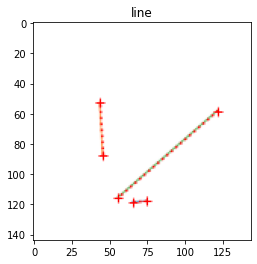

In [8]:
def testerxo():
    index = 95
    example, label, sample_weight = next(data_generator(100))
    image = example['image'][index]
    class_id = label['class_out'][index]
    pred_coords = label['line_out'][index]

    count, coords = extractor(class_id, pred_coords)

    image = plot_line(image, coords, norm=True)

    plt.imshow(image)
    plt.title('line')
    plt.show()

testerxo()

***
# MODEL

In [9]:
def modelTester():
    input_ = Input(shape=(image_height, image_width, 3), name='image')

    x = input_

    for i in range(0, 5):
      n_filters = 2**(4 + i)
      x = Conv2D(n_filters, 3, activation='relu')(x)
      x = BatchNormalization()(x)
      x = MaxPool2D(2)(x)
    
    x1 = Conv2D(1, (1,1), name="class_out")(x)
    x2 = Conv2D(4, (1,1), name="line_out")(x)
    
    model = tf.keras.models.Model(input_, [x1,x2])
    model.summary()
    return model
    
model = modelTester()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 398, 398, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 398, 398, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 199, 199, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
def model1():
    h, w = image_height, image_width
    
    backbone = keras.applications.MobileNet(input_shape=(h,w,3), include_top=False)
    
    x = x0   = keras.Input(shape=(h,w,3), name='image')
    x        = backbone(x)
    
    x1 = Conv2D(1, (1,1), name="class_out")(x)
    x2 = Conv2D(4, (1,1), name="line_out")(x)
    model    = keras.Model(inputs=x0, outputs=[x1,x2])
    
    return model

#model = model1()
#model.summary()

In [11]:
model.compile(
    loss={
        #from_logits=True if class_out has no activation function
        #from_logits=False if class_out has sigmoid activation
        'class_out': keras.losses.BinaryCrossentropy(from_logits=True),
        'line_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy',
        'line_out': [tf.keras.metrics.MeanAbsoluteError()]
    },
)

In [12]:
def test_model(model, test_datagen):

    example, label, sample_weight = next(test_datagen)

    image = example['image']
    class_id = label['class_out']

    #gtruth lines
    coords = label['line_out']
    gtcount, gtcoords = extractor(class_id[0], coords[0])

    #predicted lines
    pred_class, pred_line = model.predict(image)
    pred_count, pred_coords = extractor(pred_class[0], pred_line[0])

    #class_id
    gt = 0 if gtcount == 0 else 1
    pred_class_name = 0 if pred_count == 0 else 1

    image = plot_line(image[0], pred_coords)

    color = 'green' if gt == pred_class_name else 'red'

    plt.imshow(np.flipud(image))

    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])

In [13]:
def test(model):
    test_datagen = data_generator(1)

    plt.figure(figsize=(16, 4))

    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
    plt.show()
  

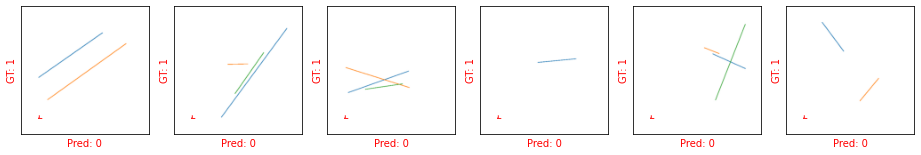

In [14]:
test(model)

In [15]:
class ShowTestImages(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    test(self.model)

# Model Training

In [16]:
def lr_schedule(epoch, lr):
  if (epoch + 1) % 5 == 0:
    lr *= 0.2
  return max(lr, 3e-7)


_ = model.fit(
    data_generator(batch_size=100),
    use_multiprocessing=True,
    workers=24,
    epochs=10,
    steps_per_epoch=len(total_files) / batch_size,
    callbacks=[
               #ShowTestImages(),
               #tf.keras.callbacks.EarlyStopping(monitor='line_out_mean_absolute_error', patience=3, mode='max'),
               #tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

Epoch 1/10
14/14 [==============================] - 107s 7s/step - loss: 736.7586 - class_out_loss: 0.9018 - line_out_loss: 735.8568 - class_out_accuracy: 0.8517 - line_out_mean_absolute_error: 7.0070
Epoch 2/10
10/14 [====================>.........] - ETA: 25s - loss: 498.1385 - class_out_loss: 0.7784 - line_out_loss: 497.3601 - class_out_accuracy: 0.8926 - line_out_mean_absolute_error: 7.5243

Process Keras_worker_ForkPoolWorker-11:
Process Keras_worker_ForkPoolWorker-21:
Process Keras_worker_ForkPoolWorker-19:
Process Keras_worker_ForkPoolWorker-24:
Process Keras_worker_ForkPoolWorker-18:
Process Keras_worker_ForkPoolWorker-23:
Process Keras_worker_ForkPoolWorker-15:
Process Keras_worker_ForkPoolWorker-20:
Process Keras_worker_ForkPoolWorker-22:
Process Keras_worker_ForkPoolWorker-8:
Process Keras_worker_ForkPoolWorker-9:
Process Keras_worker_ForkPoolWorker-10:
Process Keras_worker_ForkPoolWorker-16:
Process Keras_worker_ForkPoolWorker-12:
Process Keras_worker_ForkPoolWorker-17:
Process Keras_worker_ForkPoolWorker-13:
Process Keras_worker_ForkPoolWorker-14:
Process Keras_worker_ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorke

KeyboardInterrupt: 

***
**Outputs after a few epochs training**

In [37]:
_x,_y,_ = next(iter(data_generator()))
_out_cls, _out_reg = model.predict(_x['image'])

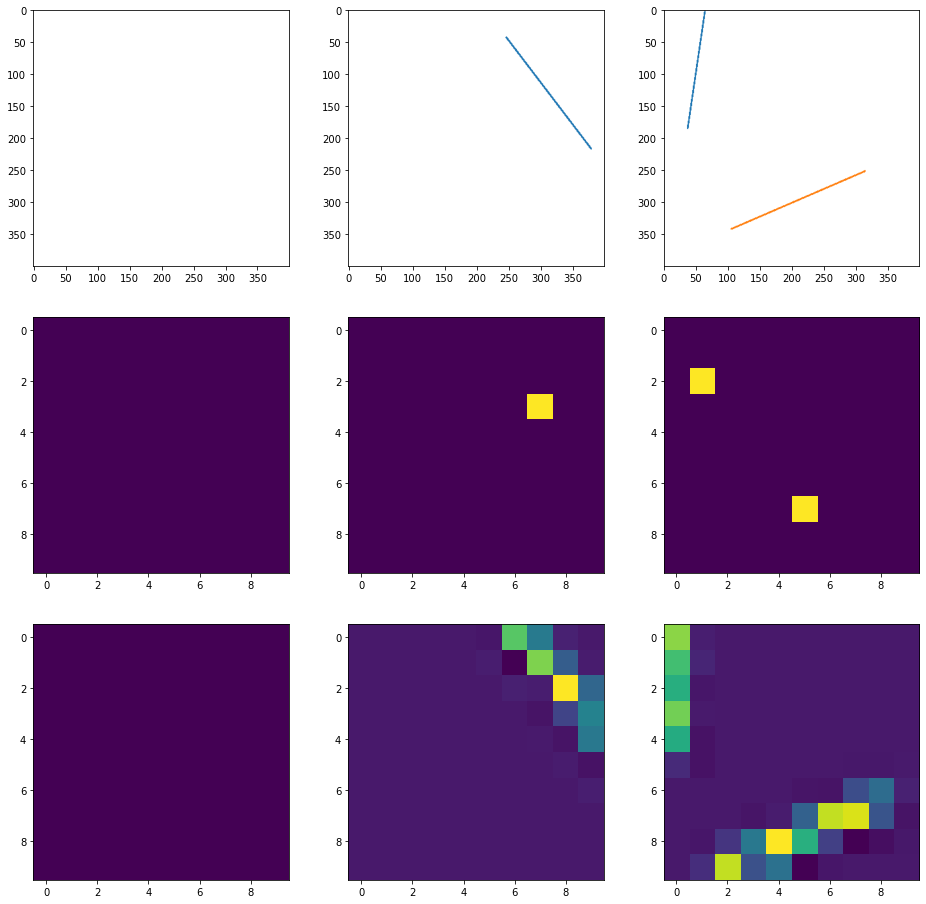

In [53]:
i = 1

plt.figure(0, (16,16))
for i,j in enumerate([3,6,10]):
    plt.subplot(3,3,i+1);   plt.imshow(_x['image'][j])
    plt.subplot(3,3,i+1+3); plt.imshow(_y['class_out'][j])
    plt.subplot(3,3,i+1+6); plt.imshow(_out_cls[j])